## Baseline model for bus 203

This notebook creates a baseline model for bus 203, and calculates the prediction error on the test set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser
import pickle
import math
%matplotlib inline
sns.set()

In [2]:
train = pickle.load(open('../203_train.p', 'rb'))
test = pickle.load(open('../203_test.p', 'rb'))

In [3]:
#bus_line_file = '../bus203_all.csv'

In [4]:
# convert timestamp columns to pandas datetimes
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['timestamp'] = train['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Europe/Stockholm')

test['timestamp'] = pd.to_datetime(test['timestamp'])
test['timestamp'] = test['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Europe/Stockholm')

In [5]:
# sanity check
print('train data rows comprise {:.4f}% of the total data'
      .format(len(train.index) / (len(train.index) + len(test.index))))
print('test data rows comprise {:.4f}% of the total data'
      .format(len(test.index) / (len(train.index) + len(test.index))))

train data rows comprise 0.7997% of the total data
test data rows comprise 0.2003% of the total data


### Calculate the median travel times for each segment in the train data

In [6]:
train.head(1)

,Unnamed: 0,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number
0,0,2018-02-16 04:48:40+01:00,JourneyStartedEvent,5432,203,58.414238,15.571015,-1.0,-1.0,NaN,1,1


Now lets calculate the median travel time in the segments of the train data, which will be used to make predictions.

In [7]:
def get_travel_time(x):
    """
    Get the travel time within the current segment
    """
    timedelta = x.max() - x.min()
    return timedelta.seconds

In [8]:
# get segment time for each segment in each journey
train['segment_time'] = train.groupby(['journey_number', 'segment_number'])['timestamp'].transform(get_travel_time)

In [9]:
test['segment_time'] = test.groupby(['journey_number', 'segment_number'])['timestamp'].transform(get_travel_time)

Now we want to get the average time it took to drive each segment. Since we have the segment time duplicated over all rows with the same journey number and segment number, we need to only take this number once to not get a skewed weighting of the average. We can group by journey_number and segment_number, and take any aggregate function (min, max, mean) since the segment time is the same for each row where the journey number and segment number are the same.

In [10]:
a = train.groupby(['journey_number', 'segment_number']).min().reset_index()

In [11]:
medians = dict(a.groupby('segment_number')['segment_time'].median())

These are our median travel times for each segment:

In [12]:
medians

{1: 188,
 2: 56,
 3: 63,
 4: 42,
 5: 52,
 6: 61,
 7: 99,
 8: 46,
 9: 157,
 10: 73,
 11: 69}

In [13]:
pickle.dump(medians, open('medians_203.p', 'wb'))

### Get the errors of the predictions on segment duration vs the actual segment durations in the test set

Now we can go through the test data and make predictions using the median travel times for each segment. Comments in code below describes the procedure.

In [14]:
 def get_prediction_error(start_time, segment_name, segment_data):
    # min() becomes the min timestamp of this slice, 
    # while start_time is the min timestamp on the whole segment 
    timedelta = segment_data['timestamp'].min() - start_time
    # get how much time the bus has already spent in this slice of the segment
    time_passed = timedelta.seconds
    # subtract that from the total time the segment takes    
    time_left = segment_data['segment_time'].iloc[0] - time_passed
    # subtract the spend time from our prediction as well
    time_pred = medians[segment_name] - time_passed
    # get the error in seconds from our prediction vs the true travel time
    error_s = time_left - time_pred
    # get error as a percentage of the true travel time left
    error_p = error_s / time_left * 100
    # get absolute values of the errors
    abs_error_s = abs(error_s)
    abs_error_p = abs(error_p)
    return error_s, error_p, abs_error_s, abs_error_p

In [15]:
i = 0
data = []
for name, group in test.groupby(['journey_number', 'segment_number']):
    seg_len = len(group.index)
    intervals = [(math.floor(seg_len * i/10), f'{i}0_p') for i in range(0, 10, 2)]
    start_time = group['timestamp'].min()
    # calculate our errors for each slice of the segment
    for (idx, interval) in intervals: 
        error_s, error_p, abs_error_s, abs_error_p = get_prediction_error(start_time, name[1], group[idx:])
        data.append([name[1], interval, error_s, error_p, abs_error_s, abs_error_p])

In [16]:
error_df = pd.DataFrame(columns=['segment', 'slice', 'error_s', 'error_p', 'abs_error_s', 'abs_error_p'], data=data)

In [17]:
error_df.head(5)

,segment,slice,error_s,error_p,abs_error_s,abs_error_p
0,1,00_p,1,0.529101,1,0.529101
1,1,20_p,1,0.653595,1,0.653595
2,1,40_p,1,0.877193,1,0.877193
3,1,60_p,1,1.333333,1,1.333333
4,1,80_p,1,2.631579,1,2.631579


# ERROR RESULTS HERE

Dataframe above holds our prediction errors on the test set. To can now get our MAPE for the segments and the segment slices, by looking at the means of the `abs_error_p` column. The values of the column "slice", such as `20_p`, `40_p`, means predictions after travelling 20%, 40% etc.

In [18]:
print('MAPE: {:.2f}%'.format(error_df[error_df.slice != '00_p']['abs_error_p'].mean()))
print('MAE: {:.2f}s'.format(error_df[error_df.slice != '00_p']['abs_error_s'].mean()))

MAPE: 60.22%
MAE: 14.86s


In [19]:
# Including 0-100% slice (slice == 00_p included)
print('MAPE: {:.2f}%'.format(error_df['abs_error_p'].mean()))
print('MAE: {:.2f}s'.format(error_df['abs_error_s'].mean()))

MAPE: 52.79%
MAE: 14.86s


In [20]:
error_df.groupby('slice').mean()

,segment,error_s,error_p,abs_error_s,abs_error_p
slice,,,,,
00_p,6.0,1.170455,-7.886602,14.857071,23.076271
20_p,6.0,1.170455,-8.912014,14.857071,27.704039
40_p,6.0,1.170455,-12.099276,14.857071,37.025354
60_p,6.0,1.170455,-19.024485,14.857071,56.284426
80_p,6.0,1.170455,-43.383345,14.857071,119.868400


In [21]:
error_df.groupby('segment').mean()

,error_s,error_p,abs_error_s,abs_error_p
segment,,,,
1,4.569444,-9.350293,26.994444,37.728035
2,-0.056944,-22.496654,11.395833,55.490590
3,0.006944,-14.364103,10.345833,42.806428
4,-2.630556,-56.477060,12.997222,97.732756
5,5.173611,10.354675,10.643056,38.603438
6,-1.455556,-21.550675,11.975000,50.491832
7,4.272222,1.284151,14.925000,31.363243
8,-3.906944,-55.746384,12.240278,85.936342
9,3.550000,-0.474394,19.269444,26.192893


In [22]:
# without 0%-100% slice/complete segment (slice == 00_p)
error_df[error_df.slice != '00_p'].groupby('segment').mean()

,error_s,error_p,abs_error_s,abs_error_p
segment,,,,
1,4.569444,-10.643542,26.994444,43.028321
2,-0.056944,-25.646461,11.395833,63.273781
3,0.006944,-16.371685,10.345833,48.801147
4,-2.630556,-64.612066,12.997222,111.652780
5,5.173611,11.778978,10.643056,44.008588
6,-1.455556,-24.606048,11.975000,57.577543
7,4.272222,1.467506,14.925000,35.765462
8,-3.906944,-63.666199,12.240278,98.062295
9,3.550000,-0.543234,19.269444,29.861182


In [23]:
error_df.groupby(['segment', 'slice']).mean()

error_s     error_p  abs_error_s  abs_error_p
segment slice                                                
1       00_p   4.569444   -4.177296    26.994444    16.526888
        20_p   4.569444   -5.146559    26.994444    20.465418
        40_p   4.569444   -6.698017    26.994444    27.200562
        60_p   4.569444   -9.951964    26.994444    41.062372
        80_p   4.569444  -20.777628    26.994444    83.384933
2       00_p  -0.056944   -9.897428    11.395833    24.357826
        20_p  -0.056944  -11.173168    11.395833    29.098901
        40_p  -0.056944  -14.979869    11.395833    39.011740
        60_p  -0.056944  -23.512279    11.395833    59.102373
        80_p  -0.056944  -52.920528    11.395833   125.882112
3       00_p   0.006944   -6.333777    10.345833    18.827551
        20_p   0.006944   -7.231386    10.345833    22.723104
        40_p   0.006944   -9.695263    10.345833    30.238377
        60_p   0.006944  -15.279300    10.345833    45.865512
        80_p   0.006944  -33.280791    10.345833    96.377595
4       00_p  -2.630556  -23.937037    12.997222    42.052662
        20_p  -2.630556  -26.691900    12.997222    49.067646
        40_p  -2.630556  -36.405195    12.997222    66.333777
        60_p  -2.630556  -57.913588    12.997222   101.907196
        80_p  -2.630556 -137.437579    12.997222   229.302500
5       00_p   5.173611    4.657465    10.643056    16.982835
        20_p   5.173611    5.976298    10.643056    20.699493
        40_p   5.173611    7.514252    10.643056    27.323192
        60_p   5.173611   11.214742    10.643056    41.464915
        80_p   5.173611   22.410620    10.643056    86.546753
6       00_p  -1.455556   -9.329184    11.975000    22.148985
        20_p  -1.455556  -10.787420    11.975000    26.656663
        40_p  -1.455556  -14.735038    11.975000    35.548327
        60_p  -1.455556  -22.826794    11.975000    53.982920
        80_p  -1.455556  -50.074938    11.975000   114.122263
7       00_p   4.272222    0.550734    14.925000    13.754370
        20_p   4.272222    0.747771    14.925000    17.044810
        40_p   4.272222    1.211277    14.925000    22.575263
        60_p   4.272222    1.497774    14.925000    33.879735
        80_p   4.272222    2.413201    14.925000    69.562040
8       00_p  -3.906944  -24.067125    12.240278    37.432534
        20_p  -3.906944  -27.414966    12.240278    43.908812
        40_p  -3.906944  -37.311816    12.240278    59.192112
        60_p  -3.906944  -58.241951    12.240278    90.589907
        80_p  -3.906944 -131.696062    12.240278   198.558347
9       00_p   3.550000   -0.199035    19.269444    11.519733
        20_p   3.550000   -0.184987    19.269444    14.182510
        40_p   3.550000   -0.283784    19.269444    18.901758
        60_p   3.550000   -0.469833    19.269444    28.476657
        80_p   3.550000   -1.234331    19.269444    57.883806
10      00_p   2.781944   -4.658226    16.148611    22.912259
        20_p   2.781944   -5.283016    16.148611    27.902102
        40_p   2.781944   -7.091653    16.148611    37.077336
        60_p   2.781944  -11.054878    16.148611    56.006837
        80_p   2.781944  -24.853561    16.148611   116.748004
11      00_p   0.570833   -9.361715    16.493056    27.323341
        20_p   0.570833  -10.842820    16.493056    32.994970
        40_p   0.570833  -14.616934    16.493056    43.876453
        60_p   0.570833  -22.731266    16.493056    66.790263
        80_p   0.570833  -49.765204    16.493056   140.184051

In [24]:
error_df.groupby(['slice', 'segment']).mean()

error_s     error_p  abs_error_s  abs_error_p
slice segment                                                
00_p  1        4.569444   -4.177296    26.994444    16.526888
      2       -0.056944   -9.897428    11.395833    24.357826
      3        0.006944   -6.333777    10.345833    18.827551
      4       -2.630556  -23.937037    12.997222    42.052662
      5        5.173611    4.657465    10.643056    16.982835
      6       -1.455556   -9.329184    11.975000    22.148985
      7        4.272222    0.550734    14.925000    13.754370
      8       -3.906944  -24.067125    12.240278    37.432534
      9        3.550000   -0.199035    19.269444    11.519733
      10       2.781944   -4.658226    16.148611    22.912259
      11       0.570833   -9.361715    16.493056    27.323341
20_p  1        4.569444   -5.146559    26.994444    20.465418
      2       -0.056944  -11.173168    11.395833    29.098901
      3        0.006944   -7.231386    10.345833    22.723104
      4       -2.630556  -26.691900    12.997222    49.067646
      5        5.173611    5.976298    10.643056    20.699493
      6       -1.455556  -10.787420    11.975000    26.656663
      7        4.272222    0.747771    14.925000    17.044810
      8       -3.906944  -27.414966    12.240278    43.908812
      9        3.550000   -0.184987    19.269444    14.182510
      10       2.781944   -5.283016    16.148611    27.902102
      11       0.570833  -10.842820    16.493056    32.994970
40_p  1        4.569444   -6.698017    26.994444    27.200562
      2       -0.056944  -14.979869    11.395833    39.011740
      3        0.006944   -9.695263    10.345833    30.238377
      4       -2.630556  -36.405195    12.997222    66.333777
      5        5.173611    7.514252    10.643056    27.323192
      6       -1.455556  -14.735038    11.975000    35.548327
      7        4.272222    1.211277    14.925000    22.575263
      8       -3.906944  -37.311816    12.240278    59.192112
      9        3.550000   -0.283784    19.269444    18.901758
      10       2.781944   -7.091653    16.148611    37.077336
      11       0.570833  -14.616934    16.493056    43.876453
60_p  1        4.569444   -9.951964    26.994444    41.062372
      2       -0.056944  -23.512279    11.395833    59.102373
      3        0.006944  -15.279300    10.345833    45.865512
      4       -2.630556  -57.913588    12.997222   101.907196
      5        5.173611   11.214742    10.643056    41.464915
      6       -1.455556  -22.826794    11.975000    53.982920
      7        4.272222    1.497774    14.925000    33.879735
      8       -3.906944  -58.241951    12.240278    90.589907
      9        3.550000   -0.469833    19.269444    28.476657
      10       2.781944  -11.054878    16.148611    56.006837
      11       0.570833  -22.731266    16.493056    66.790263
80_p  1        4.569444  -20.777628    26.994444    83.384933
      2       -0.056944  -52.920528    11.395833   125.882112
      3        0.006944  -33.280791    10.345833    96.377595
      4       -2.630556 -137.437579    12.997222   229.302500
      5        5.173611   22.410620    10.643056    86.546753
      6       -1.455556  -50.074938    11.975000   114.122263
      7        4.272222    2.413201    14.925000    69.562040
      8       -3.906944 -131.696062    12.240278   198.558347
      9        3.550000   -1.234331    19.269444    57.883806
      10       2.781944  -24.853561    16.148611   116.748004
      11       0.570833  -49.765204    16.493056   140.184051

## Plotting histograms of our errors

#### Percentage errors

/home/max/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/max/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/max/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


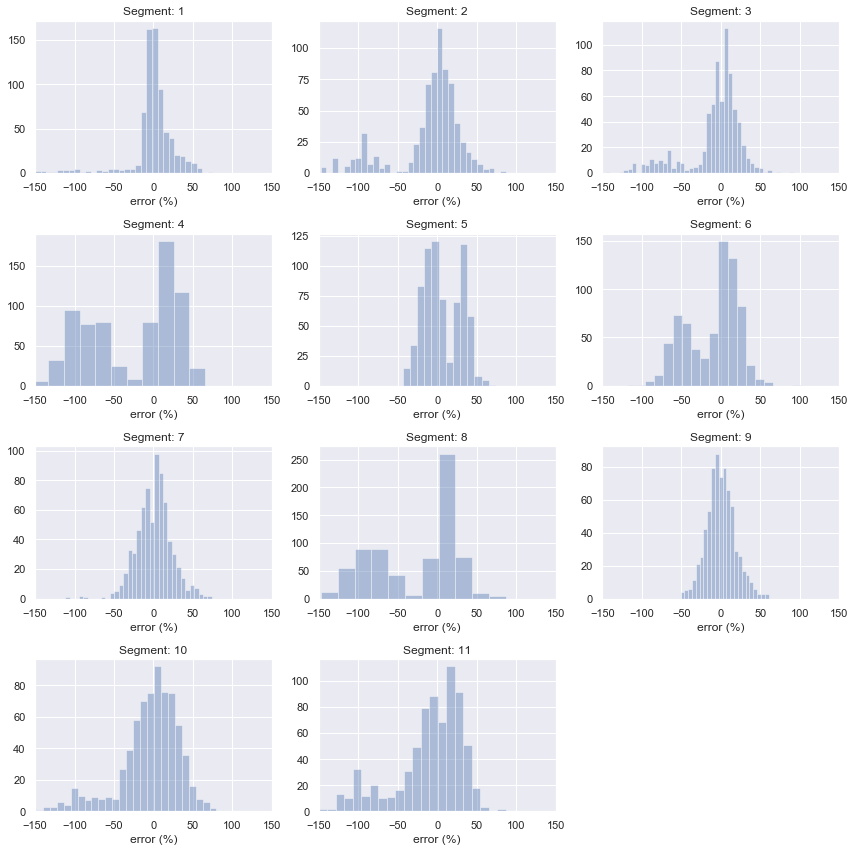

In [25]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    _=sns.distplot(error_df[(error_df.segment == i+1) & (error_df.slice == '20_p')].error_p, kde=False, ax=ax)
    ax.set_title(f'Segment: {i+1}')
    ax.set_xlabel('error (%)')
    ax.set_xlim(-150, 150)
fig.delaxes(ax)
plt.tight_layout()
plt.show()

#### Errors in seconds

/home/max/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/max/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/max/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


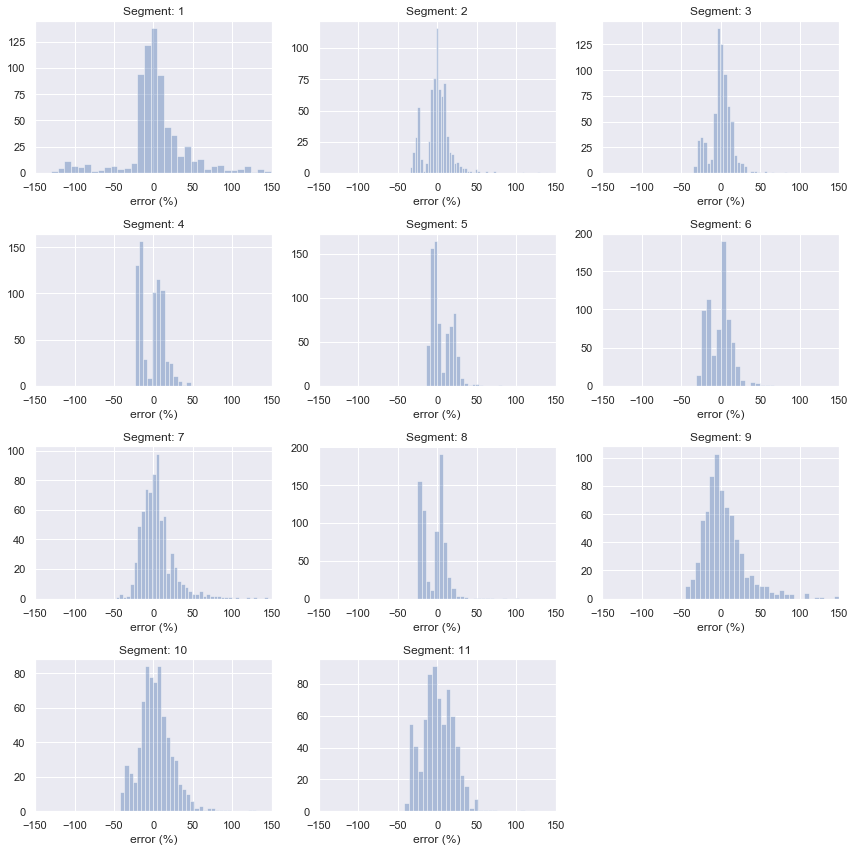

In [26]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    _=sns.distplot(error_df[(error_df.segment == i+1) & (error_df.slice == '20_p')].error_s, kde=False, ax=ax)
    ax.set_title(f'Segment: {i+1}')
    ax.set_xlabel('error (%)')
    ax.set_xlim(-150, 150)
fig.delaxes(ax)
plt.tight_layout()
plt.show()